In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
from sklearn.metrics import confusion_matrix, accuracy_score

Le résulat de cette cellule est un dataframe avec la liste des tags par carton avec le nombre de tags dans chaque carton

Les cartons sont dans la cellule refListId_actual. Dans la colonne Q refList_actual on a le nombre de tags par carton

In [2]:
pathfile='data_anonymous'

# reflist: list of epc in each box
reflist=pd.DataFrame()
# 
files=os.listdir(pathfile) # retourne une liste des fichiers dans le répertoire pathfile
for file in files:
    #print(file)
    if file.startswith('reflist_'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',').reset_index(drop=True)[['Epc']]
        temp['refListId']=file.split('.')[0]
        reflist = pd.concat([reflist, temp])
reflist=reflist.rename(columns={'refListId':'refListId_actual'})
reflist['refListId_actual']=reflist['refListId_actual'].apply(lambda x:int(x[8:]))
Q_refListId_actual=reflist.groupby('refListId_actual')['Epc'].nunique().rename('Q refListId_actual').reset_index(drop=False)
reflist=pd.merge(reflist,Q_refListId_actual,on='refListId_actual',how='left')
reflist.head(130)

,Epc,refListId_actual,Q refListId_actual
0,epc_90,0,16
1,epc_91,0,16
2,epc_92,0,16
3,epc_93,0,16
4,epc_94,0,16
...,...,...,...
125,epc_111,6,24
126,epc_112,6,24
127,epc_113,6,24
128,epc_114,6,24


Tags: logtime, epc, rssi, ant, loc

In [3]:
# pathfile=r'data_anonymous'
# 
# df : rfid readings
tags=pd.DataFrame()
# 
files=os.listdir(pathfile)
for file in files:
    #print(file)
    if file.startswith('ano_APTags'):
        temp=pd.read_csv(os.path.join(pathfile,file),sep=',')
        tags=pd.concat([tags,temp])
tags['LogTime']=pd.to_datetime (tags['LogTime'] ,format='%Y-%m-%d-%H:%M:%S') 
tags['TimeStamp']=tags['TimeStamp'].astype(float)
tags['Rssi']=tags['Rssi'].astype(float)
tags=tags.drop(['Reader','EmitPower','Frequency'],axis=1).reset_index(drop=True)
tags=tags[['LogTime', 'Epc', 'Rssi', 'Ant']]
# antennas 1 and 2 are facing the box when photocell in/out 
Ant_loc=pd.DataFrame({'Ant':[1,2,3,4],'loc':['in','in','out','out']})
tags=pd.merge(tags,Ant_loc,on=['Ant'])
tags=tags.sort_values('LogTime').reset_index(drop=True)
tags.head()

,LogTime,Epc,Rssi,Ant,loc
0,2019-11-07 15:32:10,epc_100,-69.0,3,out
1,2019-11-07 15:32:10,epc_97,-69.0,3,out
2,2019-11-07 15:32:10,epc_97,-65.0,3,out
3,2019-11-07 15:32:10,epc_99,-70.0,3,out
4,2019-11-07 15:32:10,epc_100,-66.0,3,out


Fenêtre de lecture

rflistId est l'id de la boxe

In [4]:
# timing: photocells a time window for each box: start/stop (ciuchStart, ciuchStop)
file='ano_supply-process.2019-11-07-CUT.csv'
timing=pd.read_csv(os.path.join(pathfile,file),sep=',')
timing['file']=file
timing['date']=pd.to_datetime(timing['date'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Start']=pd.to_datetime(timing['ciuchStart'],format='%d/%m/%Y %H:%M:%S,%f')
timing['Stop']=pd.to_datetime(timing['ciuchStop'],format='%d/%m/%Y %H:%M:%S,%f')
timing['timestampStart']=timing['timestampStart'].astype(float)
timing['timestampStop']=timing['timestampStop'].astype(float)
timing=timing.sort_values('date')
timing.loc[:,'refListId']=timing.loc[:,'refListId'].apply(lambda x:int(x[8:]))
timing=timing[['refListId', 'Start', 'Stop']]
timing[:12]

,refListId,Start,Stop
0,0,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197
1,1,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463
2,2,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447
3,3,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591
4,4,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528
5,5,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278
6,6,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685
7,7,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611
8,8,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158
9,9,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051


Fenêtre de décision: full window

In [5]:
# Start_up starts upstream Start, half way in between the previous stop and the actual start
timing[['Stop_last']]=timing[['Stop']].shift(1)
timing[['refListId_last']]=timing[['refListId']].shift(1)
timing['Startup']=timing['Start'] - (timing['Start'] - timing['Stop_last'])/2
# timing start: 10sec before timing
timing.loc[0,'refListId_last']=timing.loc[0,'refListId']
timing.loc[0,'Startup']=timing.loc[0,'Start']-datetime.timedelta(seconds=10)
timing.loc[0,'Stop_last']=timing.loc[0,'Startup']-datetime.timedelta(seconds=10)
timing['refListId_last']=timing['refListId_last'].astype(int)
# 
timing['Stopdown']= timing['Startup'].shift(-1)
timing.loc[len(timing)-1,'Stopdown']=timing.loc[len(timing)-1,'Stop']+datetime.timedelta(seconds=10)
timing=timing[['refListId', 'refListId_last','Startup', 'Start','Stop','Stopdown']]
timing.head(30)

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000
2,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500
3,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000
4,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000
5,5,4,2019-11-07 18:54:27.475000,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278,2019-11-07 18:54:33.115500
6,6,5,2019-11-07 18:54:33.115500,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685,2019-11-07 18:54:38.757000
7,7,6,2019-11-07 18:54:38.757000,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611,2019-11-07 18:54:44.497000
8,8,7,2019-11-07 18:54:44.497000,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158,2019-11-07 18:54:50.140000
9,9,8,2019-11-07 18:54:50.140000,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051,2019-11-07 18:54:55.894500


In [6]:
# box 0 always starts
timing[timing['refListId']==0].head(20)

,refListId,refListId_last,Startup,Start,Stop,Stopdown
0,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000
10,0,9,2019-11-07 18:54:55.894500,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765000
20,0,9,2019-11-07 18:55:53.460500,2019-11-07 18:55:55.497,2019-11-07 18:55:57.377,2019-11-07 18:55:59.567500
30,0,9,2019-11-07 18:56:51.317000,2019-11-07 18:56:53.344,2019-11-07 18:56:55.215,2019-11-07 18:56:57.241500
40,0,9,2019-11-07 18:58:02.390500,2019-11-07 18:58:04.351,2019-11-07 18:58:06.212,2019-11-07 18:58:11.428000
50,0,9,2019-11-07 18:59:12.578000,2019-11-07 18:59:15.434,2019-11-07 18:59:17.301,2019-11-07 18:59:19.361000
60,0,9,2019-11-07 19:00:11.355000,2019-11-07 19:00:13.213,2019-11-07 19:00:15.107,2019-11-07 19:00:17.173500
70,0,9,2019-11-07 19:01:08.444500,2019-11-07 19:01:10.422,2019-11-07 19:01:12.311,2019-11-07 19:01:14.344500
80,0,9,2019-11-07 19:02:06.147000,2019-11-07 19:02:08.207,2019-11-07 19:02:10.091,2019-11-07 19:02:12.092500
90,0,9,2019-11-07 19:03:30.097500,2019-11-07 19:03:37.718,2019-11-07 19:03:39.566,2019-11-07 19:03:41.560000


In [7]:
# t0_run = a new run starts when box 0 shows up
# t0_run: c'est l'instant à partir duquel commence un run, chaque run commence avec la boxe 0
# run : id du run
t0_run=timing[timing['refListId']==0] [['Startup']]
t0_run=t0_run.rename(columns={'Startup':'t0_run'})
t0_run=t0_run.groupby('t0_run').size().cumsum().rename('run').reset_index(drop=False)
t0_run=t0_run.sort_values('t0_run')
# 
# each row in timing is merged with a last row in t0_run where t0_run (ciuchstart) <= timing (ciuchstart)
timing=pd.merge_asof(timing,t0_run,left_on='Startup',right_on='t0_run', direction='backward')
timing=timing.sort_values('Stop')
timing=timing[['run', 'refListId', 'refListId_last', 'Startup','Start','Stop','Stopdown','t0_run']]
timing.head(20)
#timing['run'].value_counts()

,run,refListId,refListId_last,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,2019-11-07 18:53:42.370000,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417000,2019-11-07 18:53:42.370000
1,1,1,0,2019-11-07 18:53:58.417000,2019-11-07 18:54:02.637,2019-11-07 18:54:04.463,2019-11-07 18:54:09.025000,2019-11-07 18:53:42.370000
2,1,2,1,2019-11-07 18:54:09.025000,2019-11-07 18:54:13.587,2019-11-07 18:54:15.447,2019-11-07 18:54:16.694500,2019-11-07 18:53:42.370000
3,1,3,2,2019-11-07 18:54:16.694500,2019-11-07 18:54:17.942,2019-11-07 18:54:19.591,2019-11-07 18:54:21.637000,2019-11-07 18:53:42.370000
4,1,4,3,2019-11-07 18:54:21.637000,2019-11-07 18:54:23.683,2019-11-07 18:54:25.528,2019-11-07 18:54:27.475000,2019-11-07 18:53:42.370000
5,1,5,4,2019-11-07 18:54:27.475000,2019-11-07 18:54:29.422,2019-11-07 18:54:31.278,2019-11-07 18:54:33.115500,2019-11-07 18:53:42.370000
6,1,6,5,2019-11-07 18:54:33.115500,2019-11-07 18:54:34.953,2019-11-07 18:54:36.685,2019-11-07 18:54:38.757000,2019-11-07 18:53:42.370000
7,1,7,6,2019-11-07 18:54:38.757000,2019-11-07 18:54:40.829,2019-11-07 18:54:42.611,2019-11-07 18:54:44.497000,2019-11-07 18:53:42.370000
8,1,8,7,2019-11-07 18:54:44.497000,2019-11-07 18:54:46.383,2019-11-07 18:54:48.158,2019-11-07 18:54:50.140000,2019-11-07 18:53:42.370000
9,1,9,8,2019-11-07 18:54:50.140000,2019-11-07 18:54:52.122,2019-11-07 18:54:54.051,2019-11-07 18:54:55.894500,2019-11-07 18:53:42.370000


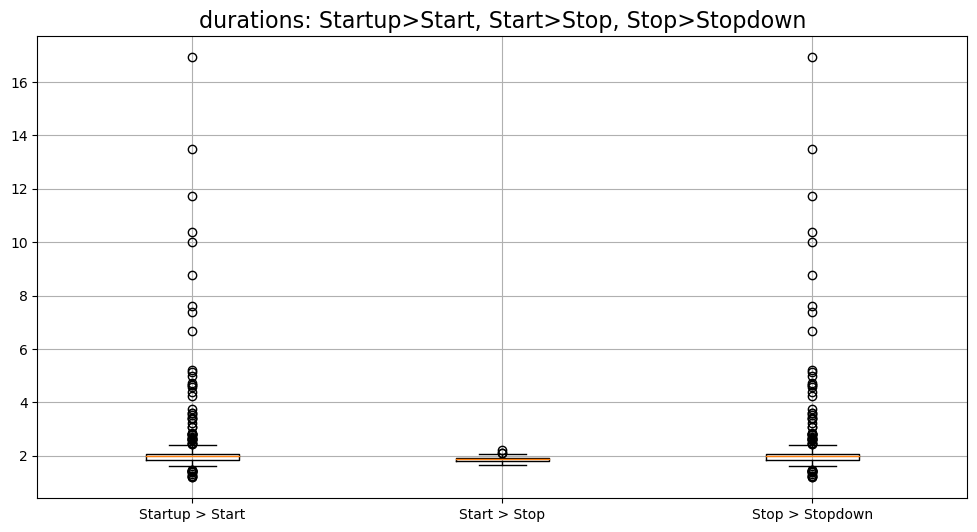

In [8]:
plt.figure(figsize=(12,6))
up=(timing['Start']-timing['Startup']).apply(lambda x:x.total_seconds())
mid=(timing['Stop']-timing['Start']).apply(lambda x:x.total_seconds())
down=(timing['Stopdown']-timing['Stop']).apply(lambda x:x.total_seconds())
plt.boxplot([up,mid,down],labels=['Startup > Start','Start > Stop','Stop > Stopdown'])
plt.grid()
plt.title('durations: Startup>Start, Start>Stop, Stop>Stopdown',size=16)
plt.show()

In [9]:
#  full window (Startup > Stopdown) is sliced in smaller slices
# Startup > Start: 11 slices named up_0, up_1, ..., up_10
# Start > Stop: 11 slices named mid_0, mid_1, ... mid_10
# Stop > Stopdown: 11 slices names down_0, down_1, ... down_10
slices=pd.DataFrame()
for i, row in timing.iterrows(): 
    ciuchStartup=row['Startup']
    ciuchStart=row['Start']
    ciuchStop=row['Stop']
    ciuchStopdown=row['Stopdown']
    steps=4
#     
    up=pd.DataFrame(index=pd.date_range(start=ciuchStartup, end=ciuchStart,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    up.index=['up_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, up])    
  
    mid=pd.DataFrame(index=pd.date_range(start=ciuchStart, end=ciuchStop,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    mid.index=['mid_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, mid])
#     
    down=pd.DataFrame(index=pd.date_range(start=ciuchStop, end=ciuchStopdown,periods=steps)).reset_index(drop=False).rename(columns={'index':'slice'})
    down.index=['down_'+str(x) for x in range(steps)]
    slices= pd.concat([slices, down])

slices=slices.reset_index(drop=False).rename(columns={'index':'slice_id'})
# 
timing_slices=pd.merge_asof(slices,timing,left_on='slice',right_on='Startup',direction='backward')
timing_slices=timing_slices[['run', 'refListId', 'refListId_last','slice_id','slice',  \
                             'Startup', 'Start', 'Stop', 'Stopdown','t0_run']]
timing_slices.head()

,run,refListId,refListId_last,slice_id,slice,Startup,Start,Stop,Stopdown,t0_run
0,1,0,0,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
1,1,0,0,up_1,2019-11-07 18:53:45.703333333,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
2,1,0,0,up_2,2019-11-07 18:53:49.036666666,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
3,1,0,0,up_3,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370
4,1,0,0,mid_0,2019-11-07 18:53:52.370000000,2019-11-07 18:53:42.370,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,2019-11-07 18:53:42.370


Fusion des dataframes tags et timing_slices: df_timing_slices

In [10]:
# merge between tags and timing
# merge_asof needs sorted df > df_ref
df = tags
df=df[(tags['LogTime']>=timing['Startup'].min()) & (df['LogTime']<=timing['Stopdown'].max())]
df=df.sort_values('LogTime')
df_timing_slices=pd.merge_asof(df,timing_slices,left_on=['LogTime'],right_on=['slice'],direction='backward')
df_timing_slices=df_timing_slices.dropna()
df_timing_slices=df_timing_slices.sort_values('slice').reset_index(drop=True)
df_timing_slices['window_run_id']  = df_timing_slices['refListId'].astype(str) +'_'+ df_timing_slices['run'].astype(str)
df_timing_slices=df_timing_slices[['run', 'window_run_id', 'Epc','refListId', 'refListId_last', 'Startup','slice_id','slice','LogTime','Start','Stop', 'Stopdown', 'Rssi', 'loc','t0_run']]
df_timing_slices

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run
0,1,0_1,epc_131,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:43,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-62.0,out,2019-11-07 18:53:42.370
1,1,0_1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-67.0,in,2019-11-07 18:53:42.370
2,1,0_1,epc_131,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-69.0,in,2019-11-07 18:53:42.370
3,1,0_1,epc_133,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-67.0,out,2019-11-07 18:53:42.370
4,1,0_1,epc_175,0,0,2019-11-07 18:53:42.370,up_0,2019-11-07 18:53:42.370000000,2019-11-07 18:53:45,2019-11-07 18:53:52.370,2019-11-07 18:53:54.197,2019-11-07 18:53:58.417,-65.0,out,2019-11-07 18:53:42.370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356063,40,1_40,epc_162,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-67.0,out,2019-11-07 19:34:37.679
356064,40,1_40,epc_187,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-65.0,out,2019-11-07 19:34:37.679
356065,40,1_40,epc_87,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-69.0,out,2019-11-07 19:34:37.679
356066,40,1_40,epc_188,1,0,2019-11-07 19:34:44.230,down_2,2019-11-07 19:34:55.305666666,2019-11-07 19:34:57,2019-11-07 19:34:46.836,2019-11-07 19:34:48.639,2019-11-07 19:34:58.639,-59.0,out,2019-11-07 19:34:37.679


In [11]:
runs_out=df_timing_slices .groupby('run')['refListId'].nunique().rename('Q refListId').reset_index(drop=False)
runs_out[runs_out['Q refListId']!=10]

,run,Q refListId
15,16,9
22,23,9
31,32,9
39,40,2


In [12]:
current_last_windows=timing_slices.drop_duplicates(['run','refListId','refListId_last'])
current_last_windows=current_last_windows[['run','refListId','refListId_last','Stop']].reset_index(drop=True)
current_last_windows[:1]

,run,refListId,refListId_last,Stop
0,1,0,0,2019-11-07 18:53:54.197


In [13]:
# runs 16 23 32 40 have missing boxes: discarded
# also run 1 is the start, no previous box: discarded
# run 18: box 0 run at the end
# 
timing=timing[~timing['run'].isin([1,18,16,23,32,40])]
timing_slices=timing_slices[~timing_slices['run'].isin([1,18,16,23,32,40])]
df_timing_slices=df_timing_slices[~df_timing_slices['run'].isin([1,18,16,23,32,40])]

df_timing_slices=df_timing_slices.sort_values(['LogTime','Epc'])
# 

In [14]:
len(timing),len(timing_slices), len(df_timing_slices)

(340, 4080, 307965)

In [15]:
df_timing_slices[:1]

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run
8970,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-68.0,in,2019-11-07 18:54:55.894500


In [16]:
# df_timing_slices['dt']=
df_timing_slices['dt']=(df_timing_slices['LogTime']-df_timing_slices['t0_run']).apply(lambda x:x.total_seconds())

In [17]:
df_timing_slices[:1]

,run,window_run_id,Epc,refListId,refListId_last,Startup,slice_id,slice,LogTime,Start,Stop,Stopdown,Rssi,loc,t0_run,dt
8970,2,0_2,epc_100,0,9,2019-11-07 18:54:55.894500,up_0,2019-11-07 18:54:55.894500,2019-11-07 18:54:56,2019-11-07 18:54:57.738,2019-11-07 18:54:59.584,2019-11-07 18:55:01.765,-68.0,in,2019-11-07 18:54:55.894500,0.1055


In [18]:
rssi_threshold=-110
df_timing_slices_threshold=df_timing_slices[df_timing_slices['Rssi']>rssi_threshold]

In [19]:
# readrate
# readrate
round(100*df_timing_slices_threshold.reset_index(drop=False).groupby(['run','loc'])['Epc'].nunique().groupby('loc').mean()\
    /reflist['Epc'].nunique(),2)

loc
in     100.00
out     99.29
Name: Epc, dtype: float64

Implémentation de la méthode analytique

In [20]:
ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max()
ana

Epc     window_run_id  slice_id  loc
epc_0   0_10           down_0    out   -67.0
                       down_2    out   -63.0
                       up_2      out   -64.0
        0_19           down_0    out   -69.0
                       mid_0     out   -68.0
                                        ... 
epc_99  9_9            down_1    out   -48.0
                       down_2    in    -61.0
                                 out   -48.0
                       mid_0     out   -71.0
                       mid_2     out   -63.0
Name: Rssi, Length: 97948, dtype: float64

In [21]:
ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)
ana

loc,Epc,window_run_id,slice_id,in,out
0,epc_0,0_10,down_0,-110.0,-67.0
1,epc_0,0_10,down_2,-110.0,-63.0
2,epc_0,0_10,up_2,-110.0,-64.0
3,epc_0,0_19,down_0,-110.0,-69.0
4,epc_0,0_19,mid_0,-110.0,-68.0
...,...,...,...,...,...
82437,epc_99,9_9,down_0,-61.0,-47.0
82438,epc_99,9_9,down_1,-61.0,-48.0
82439,epc_99,9_9,down_2,-61.0,-48.0
82440,epc_99,9_9,mid_0,-110.0,-71.0


In [22]:
order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
order['order']=order.index
order

,slice_id,order
0,down_3,0
1,up_0,1
2,up_1,2
3,up_2,3
4,up_3,4
5,mid_0,5
6,mid_1,6
7,mid_2,7
8,mid_3,8
9,down_0,9


In [23]:
ana=pd.merge(ana, order, on='slice_id', how='left')
ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
ana

,Epc,window_run_id,slice_id,in,out,order
0,epc_0,0_10,down_0,-110.0,-67.0,9
1,epc_0,0_10,down_2,-110.0,-63.0,11
2,epc_0,0_10,up_2,-110.0,-64.0,3
3,epc_0,0_19,down_0,-110.0,-69.0,9
4,epc_0,0_19,mid_0,-110.0,-68.0,5
...,...,...,...,...,...,...
82437,epc_99,9_9,down_0,-61.0,-47.0,9
82438,epc_99,9_9,down_1,-61.0,-48.0,10
82439,epc_99,9_9,down_2,-61.0,-48.0,11
82440,epc_99,9_9,mid_0,-110.0,-71.0,5


In [24]:
ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
ana_out

,Epc,window_run_id,slice_id,in,out,order
82439,epc_99,9_9,down_2,-61.0,-48.0,11
82434,epc_99,9_8,down_2,-67.0,-44.0,11
82430,epc_99,9_7,down_2,-63.0,-47.0,11
82424,epc_99,9_6,down_2,-61.0,-47.0,11
82421,epc_99,9_5,down_2,-66.0,-50.0,11
...,...,...,...,...,...,...
7,epc_0,0_29,down_0,-110.0,-65.0,9
6,epc_0,0_27,down_0,-110.0,-69.0,9
5,epc_0,0_21,down_1,-110.0,-65.0,10
3,epc_0,0_19,down_0,-110.0,-69.0,9


In [25]:
ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])
ana_in

,Epc,window_run_id,slice_id,in,out,order
171,epc_0,5_10,up_2,-51.0,-110.0,3
175,epc_0,5_11,up_2,-49.0,-69.0,3
180,epc_0,5_12,up_2,-56.0,-63.0,3
186,epc_0,5_13,up_2,-50.0,-110.0,3
189,epc_0,5_14,mid_0,-51.0,-110.0,5
...,...,...,...,...,...,...
82143,epc_99,1_6,up_0,-61.0,-110.0,1
82146,epc_99,1_7,up_1,-63.0,-110.0,2
82149,epc_99,1_8,up_0,-62.0,-110.0,1
82152,epc_99,1_9,up_1,-62.0,-110.0,2


In [26]:
ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
ana

,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2
...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1


In [27]:
ana = pd.merge(ana, reflist, on='Epc', how='left')

In [28]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in/out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    print("Matrice de confusion :")
    print(conf_mat)
    print("\nAccuracy :", acc)
    
    return ana
ana=analytical(df_timing_slices, timing_slices)
ana

Matrice de confusion :
[[   5  511    0    0    0    0    0    0    0    0]
 [  10  333    0    0    0    0    0    0    0    0]
 [   8 1051    0    0    0    0    0    0    0    0]
 [  40  296    0    0    0    0    0    0    0    0]
 [  35  339    0    0    0    0    0    0    0    0]
 [   5 1213    0    0    0    0    0    0    0    0]
 [   6  779    0    0    0    0    0    0    0    0]
 [  57  332    0    0    0    0    0    0    0    0]
 [   9 1209    0    0    0    0    0    0    0    0]
 [  20  268    0    0    0    0    0    0    0    0]]

Accuracy : 0.05179282868525897


,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT,refListId_actual,Q refListId_actual,pred_ana_bool
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1,5,40,True
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2,5,40,True
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1,5,40,True
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1,5,40,True
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2,5,40,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2,0,16,True
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1,0,16,True
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2,0,16,True
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1,0,16,False


In [30]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    ana['runs']= ana['window_run_id'].apply(lambda x:x.split('_')[1]).astype('int64')
    true_counts = ana.groupby(['refListId_actual', 'runs'])['pred_ana_bool'].sum()
    
    

    # Pour afficher 100 lignes au maximum
    pd.set_option('display.max_rows', 100)

    # Maintenant, quand vous imprimez, cela devrait afficher jusqu'à 100 lignes.
    print(true_counts)

    return ana
ana=analytical(df_timing_slices, timing_slices)
ana

refListId_actual  runs
0                 2       16
                  3       15
                  4       16
                  5       15
                  6       16
                          ..
9                 35       8
                  36       8
                  37       7
                  38       8
                  39       8
Name: pred_ana_bool, Length: 339, dtype: int64


,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT,refListId_actual,Q refListId_actual,pred_ana_bool,runs
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1,5,40,True,10
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2,5,40,True,11
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1,5,40,True,12
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1,5,40,True,13
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2,5,40,True,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2,0,16,True,7
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1,0,16,True,8
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2,0,16,True,9
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1,0,16,False,14


refListId_actual  runs       
0                 2     True     16
                  3     True     15
                  4     True     16
                  5     True     15
                  6     True     16
                  7     True     14
                  8     True     14
                  9     True     15
                  10    True     15
                  11    True     14
                  12    True     16
                  13    True     14
                        False     2
                  14    True     15
                        False     1
                  15    True     16
                  17    True     15
                  19    True     16
                  20    True     15
                  21    True     15
                  22    True     15
                        False     1
                  24    True     16
                  25    True     16
                  26    True     14
                  27    True     15
                  28    True     1

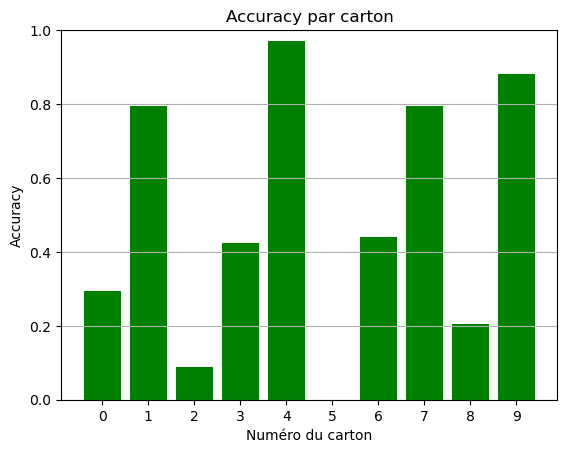

,Epc,window_run_id,slice_id_IN,in_IN,out_IN,order_IN,slice_id_OUT,in_OUT,out_OUT,order_OUT,refListId_actual,Q refListId_actual,pred_ana_bool,runs
0,epc_0,5_10,up_2,-51.0,-110.0,3,up_0,-110.0,-47.0,1,5,40,True,10
1,epc_0,5_11,up_2,-49.0,-69.0,3,up_1,-63.0,-47.0,2,5,40,True,11
2,epc_0,5_12,up_2,-56.0,-63.0,3,up_0,-110.0,-46.0,1,5,40,True,12
3,epc_0,5_13,up_2,-50.0,-110.0,3,up_0,-64.0,-45.0,1,5,40,True,13
4,epc_0,5_14,mid_0,-51.0,-110.0,5,up_1,-67.0,-47.0,2,5,40,True,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6521,epc_99,0_7,up_2,-51.0,-62.0,3,up_1,-55.0,-49.0,2,0,16,True,7
6522,epc_99,0_8,up_2,-52.0,-60.0,3,up_0,-61.0,-48.0,1,0,16,True,8
6523,epc_99,0_9,up_2,-44.0,-61.0,3,up_1,-59.0,-48.0,2,0,16,True,9
6524,epc_99,1_14,up_1,-62.0,-110.0,2,up_0,-63.0,-62.0,1,0,16,False,14


In [93]:
def analytical(df_timing_slices, timing_slices):
    ana = df_timing_slices.groupby(['Epc', 'window_run_id', 'slice_id', 'loc']) ['Rssi'].max().unstack('loc', fill_value =- 110).reset_index(drop=False)

    order=pd.DataFrame(timing_slices['slice_id'].unique(), columns=['slice_id'])
    order['order']=order.index

    ana=pd.merge(ana, order, on='slice_id', how='left')
    ana = ana [['Epc', 'window_run_id', 'slice_id', 'in', 'out', 'order']]
    
    # last subslice_id with out>in
    ana_out =ana [ ana['out']>ana['in'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=False).drop_duplicates(['Epc', 'window_run_id'])
    
    # first subslice_id with in<out
    ana_in =ana [ ana['in']>ana['out'] ].sort_values(['Epc', 'window_run_id', 'order'], ascending=True).drop_duplicates(['Epc', 'window_run_id'])

    ana = pd.merge(ana_in, ana_out, on=['Epc', 'window_run_id'], suffixes=['_IN', '_OUT'], how='inner').sort_values(['Epc', 'window_run_id'])
    ana = pd.merge(ana, reflist, on='Epc', how='left')

    ana['pred_ana_bool']= ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64') == ana['refListId_actual']
    
    #conf_mat = confusion_matrix(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Calcul de l'exactitude (accuracy).
    #acc = accuracy_score(ana['window_run_id'].apply(lambda x:x.split('_')[0]).astype('int64'), ana['pred_ana_bool'])

    # Affichage de la matrice de confusion et de l'accuracy.
    #print("Matrice de confusion :")
    #print(conf_mat)
    #print("\nAccuracy :", acc)
    # Compter les True et False dans 'pred_ana_bool' pour chaque 'refListId_actual'
    # Compter uniquement le nombre de True dans 'pred_ana_bool' pour chaque 'refListId_actual'
    
    ana['runs']= ana['window_run_id'].apply(lambda x:x.split('_')[1]).astype('int64')
    true_counts = ana.groupby(['refListId_actual', 'runs']).agg(
    unique_Epcs=pd.NamedAgg(column='Epc', aggfunc=lambda x: list(x.unique())),
    sum_pred_ana_bool=pd.NamedAgg(column='pred_ana_bool', aggfunc='sum')
        )
    

    # Pour afficher 100 lignes au maximum
    pd.set_option('display.max_rows', 100)

    # Maintenant, quand vous imprimez, cela devrait afficher jusqu'à 100 lignes.
    #print(true_counts)
    
    #true_counts.to_excel('counts.xlsx', sheet_name = 'True Counts')
    true_false_counts = ana.groupby(['refListId_actual', 'runs'])['pred_ana_bool'].apply(lambda x: x.value_counts())
    print(true_false_counts.head(30))
    
    y_test=df['sum_pred_ana_bool']
    y_pred=df['true_values']

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.2f}")
    
    # Supposons que df est votre DataFrame
    accuracies = []
    cartons = range(10)

    # Collecter les valeurs d'accuracy pour chaque carton
    for i in cartons:
        filtered_df = df[df['refListId'] == i]
        y_test = filtered_df['sum_pred_ana_bool']
        y_pred = filtered_df['true_values']
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"Accuracy carton {i}: {acc:.2f}")

    # Créer un diagramme en barres
    plt.bar(cartons, accuracies, color='green')
    plt.title('Accuracy par carton')
    plt.xlabel('Numéro du carton')
    plt.ylabel('Accuracy')
    plt.xticks(cartons)
    plt.ylim([0, 1])  # L'accuracy est toujours entre 0 et 1
    plt.grid(axis='y')  # Ajouter une grille horizontale pour la lisibilité
    plt.show()
    
   
    return ana
ana=analytical(df_timing_slices, timing_slices)
ana  


In [35]:
# Chemin vers le fichier Excel
file_path = r'counts.xlsx'

# Charger le fichier Excel dans un DataFrame
df = pd.read_excel(file_path)

# Afficher les premières lignes du DataFrame
df.head()

,refListId_actual,runs,unique_Epcs,sum_pred_ana_bool,true_values,refListId
0,0.0,2,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0
1,NaN,3,"['epc_100', 'epc_101', 'epc_102', 'epc_104', '...",15,16,0
2,NaN,4,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0
3,NaN,5,"['epc_100', 'epc_101', 'epc_102', 'epc_104', '...",15,16,0
4,NaN,6,"['epc_100', 'epc_101', 'epc_102', 'epc_103', '...",16,16,0


In [36]:
y_test=df['sum_pred_ana_bool']
y_pred=df['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.49


In [59]:
# Filtrage du DataFrame basé sur la condition
filtered_df0 = df[df['refListId'] == 0]

y_test=filtered_df0['sum_pred_ana_bool']
y_pred=filtered_df0['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 0: {accuracy:.2f}")

Accuracy carton 0: 0.29


In [58]:
# Filtrage du DataFrame basé sur la condition
filtered_df1 = df[df['refListId'] == 1]

y_test=filtered_df1['sum_pred_ana_bool']
y_pred=filtered_df1['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 1: {accuracy:.2f}")

Accuracy carton 1: 0.79


In [41]:
# Filtrage du DataFrame basé sur la condition
filtered_df2 = df[df['refListId'] == 2]

y_test=filtered_df2['sum_pred_ana_bool']
y_pred=filtered_df2['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 2: {accuracy:.2f}")

Accuracy carton 1: 0.09


In [57]:
# Filtrage du DataFrame basé sur la condition
filtered_df2 = df[df['refListId'] == 2]

y_test=filtered_df2['sum_pred_ana_bool']
y_pred=filtered_df2['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 2: {accuracy:.2f}")

Accuracy carton 2: 0.09


In [56]:
# Filtrage du DataFrame basé sur la condition
filtered_df3 = df[df['refListId'] == 3]

y_test=filtered_df3['sum_pred_ana_bool']
y_pred=filtered_df3['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 3: {accuracy:.2f}")

Accuracy carton 3: 0.42


In [55]:
# Filtrage du DataFrame basé sur la condition
filtered_df4 = df[df['refListId'] == 4]

y_test=filtered_df4['sum_pred_ana_bool']
y_pred=filtered_df4['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 4: {accuracy:.2f}")

Accuracy carton 4: 0.97


In [54]:
# Filtrage du DataFrame basé sur la condition
filtered_df5 = df[df['refListId'] == 5]

y_test=filtered_df5['sum_pred_ana_bool']
y_pred=filtered_df5['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 5: {accuracy:.2f}")

Accuracy carton 5: 0.00


In [80]:
# Filtrage du DataFrame basé sur la condition
filtered_df6 = df[df['refListId'] == 6]

y_test=filtered_df6['sum_pred_ana_bool']
y_pred=filtered_df6['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 6: {accuracy:.2f}")

Accuracy carton 6: 0.44


In [52]:
# Filtrage du DataFrame basé sur la condition
filtered_df7 = df[df['refListId'] == 7]

y_test=filtered_df7['sum_pred_ana_bool']
y_pred=filtered_df7['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 7: {accuracy:.2f}")

Accuracy carton 7: 0.79


In [60]:
# Filtrage du DataFrame basé sur la condition
filtered_df8 = df[df['refListId'] == 8]

y_test=filtered_df8['sum_pred_ana_bool']
y_pred=filtered_df8['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 8: {accuracy:.2f}")


Accuracy carton 8: 0.21


,refListId_actual,runs,unique_Epcs,sum_pred_ana_bool,true_values,refListId
271,8.0,2,"['epc_41', 'epc_42', 'epc_43', 'epc_44', 'epc_...",32,40,8
272,NaN,3,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",38,40,8
273,NaN,4,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",30,40,8
274,NaN,5,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",38,40,8
275,NaN,6,"['epc_41', 'epc_42', 'epc_43', 'epc_44', 'epc_...",36,40,8
276,NaN,7,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",37,40,8
277,NaN,8,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",40,40,8
278,NaN,9,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",34,40,8
279,NaN,10,"['epc_40', 'epc_41', 'epc_42', 'epc_43', 'epc_...",38,40,8
280,NaN,11,"['epc_41', 'epc_42', 'epc_43', 'epc_44', 'epc_...",26,40,8


In [50]:
# Filtrage du DataFrame basé sur la condition
filtered_df9 = df[df['refListId'] == 9]

y_test=filtered_df9['sum_pred_ana_bool']
y_pred=filtered_df9['true_values']

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy carton 9: {accuracy:.2f}")

Accuracy carton 9: 0.88


Accuracy carton 0: 0.29
Accuracy carton 1: 0.79
Accuracy carton 2: 0.09
Accuracy carton 3: 0.42
Accuracy carton 4: 0.97
Accuracy carton 5: 0.00
Accuracy carton 6: 0.44
Accuracy carton 7: 0.79
Accuracy carton 8: 0.21
Accuracy carton 9: 0.88


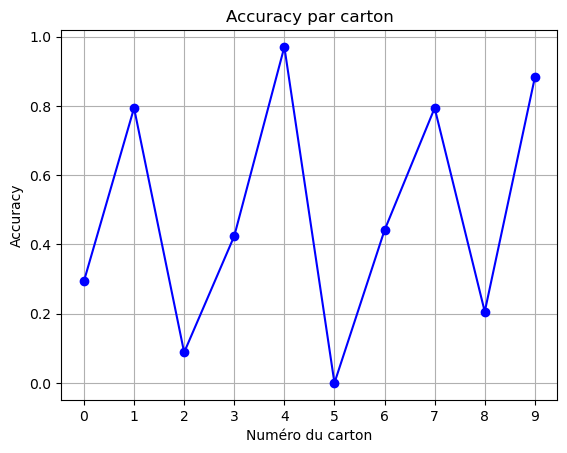

In [87]:
accuracies = []
for i in range(10):
    filtered_df = df[df['refListId'] == i]
    y_test = filtered_df['sum_pred_ana_bool']
    y_pred = filtered_df['true_values']
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Accuracy carton {i}: {acc:.2f}")

# Tracer la courbe des accuracies
plt.plot(range(10), accuracies, marker='o', linestyle='-', color='b')
plt.title('Accuracy par carton')
plt.xlabel('Numéro du carton')
plt.ylabel('Accuracy')
plt.xticks(range(10))  # Pour s'assurer que les étiquettes des x-axis correspondent au numéro des cartons
plt.grid(True)
plt.show()

Accuracy carton 0: 0.29
Accuracy carton 1: 0.79
Accuracy carton 2: 0.09
Accuracy carton 3: 0.42
Accuracy carton 4: 0.97
Accuracy carton 5: 0.00
Accuracy carton 6: 0.44
Accuracy carton 7: 0.79
Accuracy carton 8: 0.21
Accuracy carton 9: 0.88


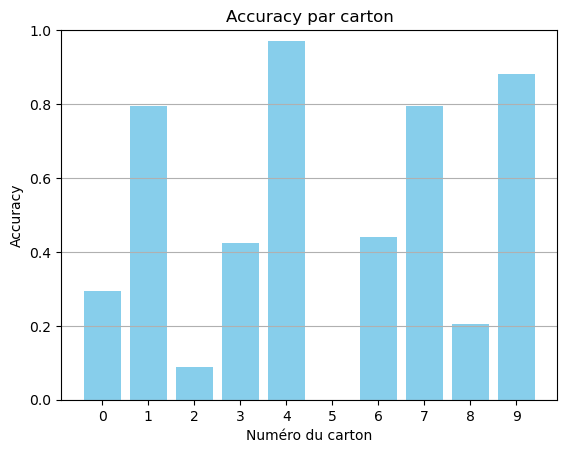

In [88]:
# Supposons que df est votre DataFrame
accuracies = []
cartons = range(10)

# Collecter les valeurs d'accuracy pour chaque carton
for i in cartons:
    filtered_df = df[df['refListId'] == i]
    y_test = filtered_df['sum_pred_ana_bool']
    y_pred = filtered_df['true_values']
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Accuracy carton {i}: {acc:.2f}")

# Créer un diagramme en barres
plt.bar(cartons, accuracies, color='skyblue')
plt.title('Accuracy par carton')
plt.xlabel('Numéro du carton')
plt.ylabel('Accuracy')
plt.xticks(cartons)
plt.ylim([0, 1])  # L'accuracy est toujours entre 0 et 1
plt.grid(axis='y')  # Ajouter une grille horizontale pour la lisibilité
plt.show()

Accuracy carton 0: 0.29
Accuracy carton 1: 0.79
Accuracy carton 2: 0.09
Accuracy carton 3: 0.42
Accuracy carton 4: 0.97
Accuracy carton 5: 0.00
Accuracy carton 6: 0.44
Accuracy carton 7: 0.79
Accuracy carton 8: 0.21
Accuracy carton 9: 0.88


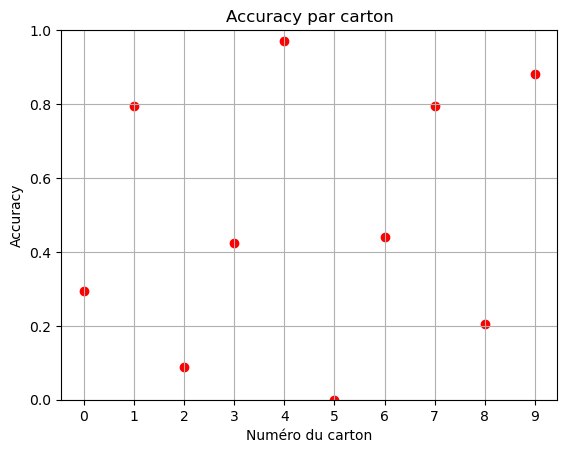

In [89]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Supposons que df est votre DataFrame
accuracies = []
cartons = range(10)

# Collecter les valeurs d'accuracy pour chaque carton
for i in cartons:
    filtered_df = df[df['refListId'] == i]
    y_test = filtered_df['sum_pred_ana_bool']
    y_pred = filtered_df['true_values']
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Accuracy carton {i}: {acc:.2f}")

# Créer un graphique à points
plt.scatter(cartons, accuracies, color='red')
plt.title('Accuracy par carton')
plt.xlabel('Numéro du carton')
plt.ylabel('Accuracy')
plt.xticks(cartons)
plt.ylim([0, 1])  # L'accuracy est toujours entre 0 et 1
plt.grid(True)
plt.show()
